<a href="https://colab.research.google.com/github/fclubb/EarthSurfaceProcesses/blob/master/Week6_ErosionRates/Part2_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: plotting erosion rates and doing extra topographic analysis



*This lesson has been written Fiona Clubb at Durham University*

In the first part of the practical we downloaded a DEM, some erosion rate data, and basin shapefiles for the Great Smoky Mountains using the OCTOPUS database. Now we're going to read these data into python and make some plots.

You can find more information about these erosion rate data and the landscape in this paper:

A. Matmon, P.R. Bierman, J. Larsen, S. Southworth, M. Pavich, M. Caffee; Temporally and spatially uniform rates of erosion in the southern Appalachian Great Smoky Mountains. _Geology_ 2003; 31 (2): 155–158. doi: https://doi.org/10.1130/0091-7613(2003)031<0155:TASURO>2.0.CO;2

This notebook shows you how to:

* Read a DEM and a shapefile into Python
* Plot erosion rate vs. mean basin slope
* Do a channel steepness analysis (see Week 3) and plot erosion rate vs. mean channel steepness.

We will do the channel steepness analysis using **lsdtopotools**. **lsdtopotools** is a software package for analysing topography developed at the University of Edinburgh, Durham University, and other institutions. 

-------------------------
### BEFORE YOU BEGIN
Remember to copy this notebook to your Google Drive using the "Copy to Drive" button 

## Upload your DEM and erosion rate data

We need to upload the data that we downloaded from OCTOPUS to Google Colaboratory. To do this, click on the small folder icon on the left hand bar and then click `Upload to Session Storage`. 

**Navigate to the DEM that you downloaded from Learn Ultra and upload the two files ``Great_Smoky_Mts.bil`` and ``Great_Smoky_Mts.hdr``.**

You also need to upload the shapefile that we created in ArcGIS/QGIS, which has the mean basin slope and erosion rate data for each basin. Shapefiles tend to be made up of 4-5 files which have different file extensions but the same filename (which you chose in the GIS program). You need to upload ALL the files that were created. For my example, I would upload all the files called ``Great_Smoky_Mts_basins_slope``:
  * Great_Smoky_Mts_basins_slope.dbf
  * Great_Smoky_Mts_basins_slope.prj
  * Great_Smoky_Mts_basins_slope.shp
  * Great_Smoky_Mts_basins_slope.shx

  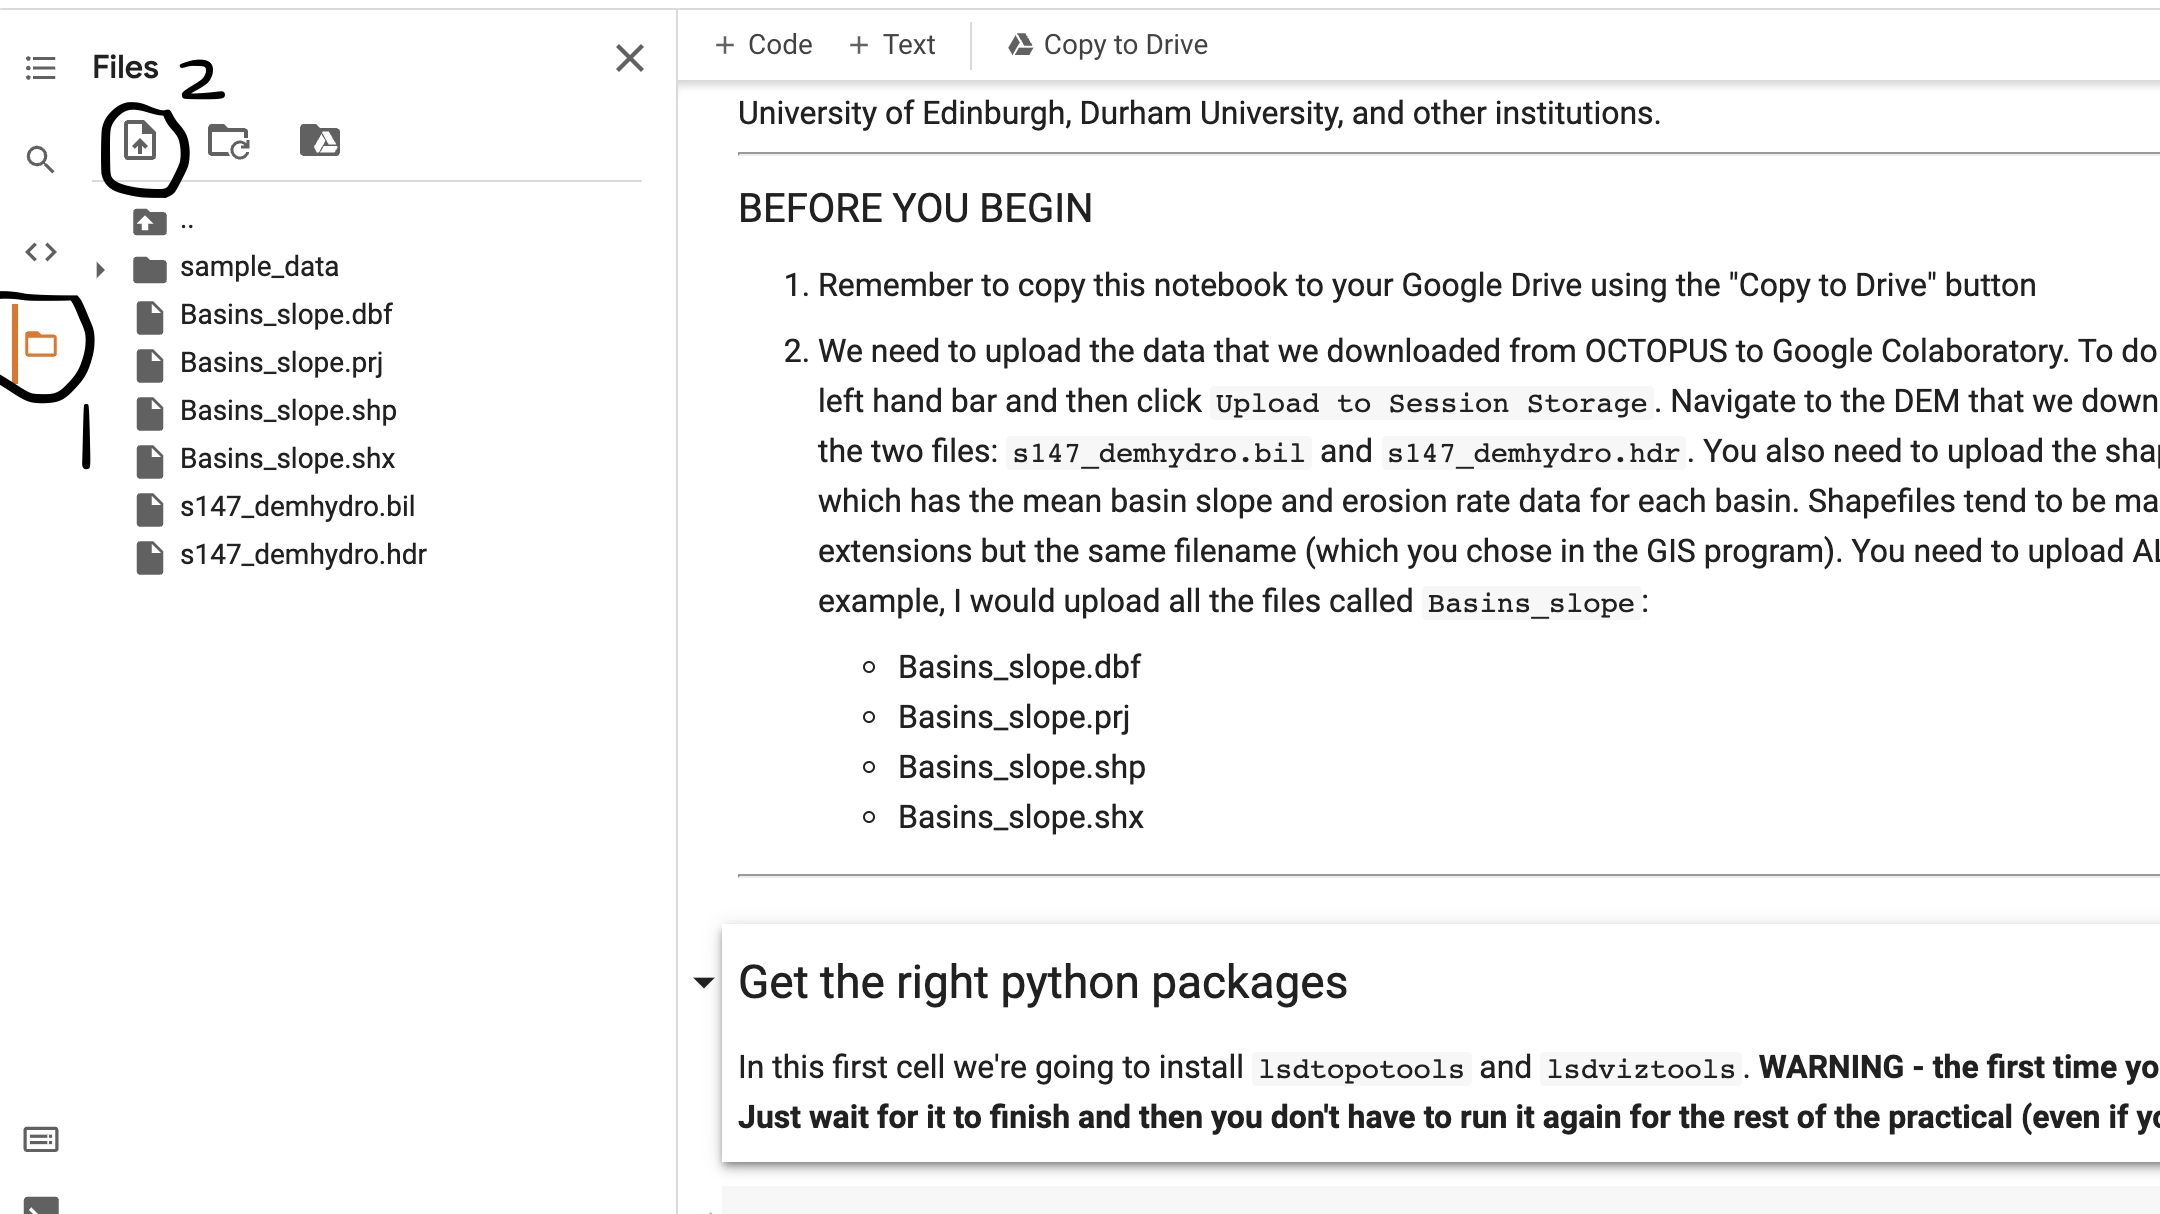

-------------------------


## Get the right python packages

In this first cell we're going to install `lsdtopotools` and `lsdviztools`. 
**WARNING - the first time you do this, it might take up to 5 minutes. Just wait for it to finish and then you don't have to run it again for the rest of the practical (even if you need to restart the kernel).**



In [ ]:
!pip install cartopy --no-binary cartopy &> /dev/null
!pip install lsdviztools lsdttparamselector &> /dev/null


First we download miniconda, which takes about 30 seconds.

In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.8.2-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT &> /dev/null
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX &> /dev/null


The next step is to set the conda channels, install mamba (because it installs lsdtopotools much faster than conda) and then finally lsdtopotools. This takes ~3.5 minutes.

In [ ]:
!conda config --add channels conda-forge &> /dev/null
!conda config --set channel_priority strict &> /dev/null
!conda install -c conda-forge -y mamba &> /dev/null
!mamba install -c conda-forge -y lsdtopotools &> /dev/null

Install Geopandas from source to fix issue with spatial joining later on.
**NOTE: This may give you an error message telling you to Restart the Runtime. If so, click "Runtime" in the top menu bar, then "Restart Runtime". You do not need to re-run the code blocks above once you've done this..**

In [ ]:
!apt install gdal-bin python-gdal python3-gdal &> /dev/null\n
# Install rtree - Geopandas requirement\n
!apt install python3-rtree &> /dev/null\n
# Install Geopandas\n
!pip install git+git://github.com/geopandas/geopandas.git &> /dev/null\n
# Install descartes - Geopandas requirement\n"
!pip install descartes

Import required packages that we need:

In [ ]:
#lsdtopotools
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw

#pandas
import pandas as pd
import geopandas as gpd

#colab
from google.colab import files

# statistics
from scipy import stats
import scipy.optimize

#general
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
%matplotlib inline

## Read in the basin shapefile


First, let's read in the basin shapefile. To do this we will use a package called ``geopandas``: this is a python package specifically designed for reading in geographic data (e.g. polygons) and analysing it. You can find more information here: https://geopandas.org/getting_started/introduction.html

In the block below, you will need to change the `shapefile_name` variable to be the name of the shapefile that you uploaded in the previous step.

In [ ]:
# Read in the shapefile to a geopandas dataframe
shapefile_name = 'Great_Smoky_Mts_basins_slope.shp'
gdf = gpd.read_file(shapefile_name)

Now we have a variable `gdf` which has the data that was in the shapefile in it (this is the same as the Attribute table that you can open in QGIS/ArcGIS. Let's look at it:

In [ ]:
gdf

This should be familiar to you from the first step of the practical: it's the same data. You might notice that the very last column of this table is called `geometry`: this is how geopandas stores the geographic information. It stores a string of coordinates which gives you the outline of the basin polygon. We can use geopandas to very quickly and easily plot the shapefiles:

In [ ]:
gdf.plot()

There you go - you can see the same basins that we could see in QGIS/ArcGIS!

## Making plots of erosion rate vs mean basin slope

In the first part of the practical, you were asked to qualitatively look at the distribution of erosion rates and mean basin slopes across the landscape. But what if we want to quantify this? To do that, we could make a scatter plot of erosion rate and mean basin slope, and then try to fit some kind of model through the data (e.g. a linear regression). First of all, let's just make a simple scatter plot. To do this we will use the python package `matplotlib`, which is a powerful package for making nice graphics. In the first step we imported it using the shorthand `plt`, so I'm just going to call `plt` here.

In [ ]:
# make a scatter plot using matplotlib. The first parameter in the brackets is the X data, and the second is the Y data. 
# You can change the column names from the geopandas table to choose what you want to plot.
# Here I am plotting erosion rate (EBE_MMKYR) and the mean basin slope that we calculated (MEAN).
# You can change the fill colour of the marker using 'color', the edge color using 'edgecolors', and the size using 's'
plt.scatter(gdf['MEAN'], gdf['EBE_MMKYR'], color = 'red', edgecolors='black', s=100)
plt.xlabel('Mean basin slope (degrees)', fontsize=14)
plt.ylabel('Catchment-averaged\n erosion rate (mm/kyr)', fontsize=14)

Although we don't have a huge number of data points, you should be able to see that there isn't a great relationship between erosion rate and mean basin slope. Let's use python to fit a linear regression through these data and check the goodness of fit. To do that we will use the `stats` function from the `scipy` package:

In [ ]:
# set the X and Y data for the linear regression
x = gdf['MEAN'].values
y = gdf['EBE_MMKYR'].values

# do the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# print out the equation of the line. We will round to 2 decimal places
print ('y = {}x + {}'.format(round(slope,2), round(intercept,2)))

# print out the R^2 value and the p value
print ('R^2: ', r_value**2)
print ('p value: ', p_value)



---


## Exercise 1

* Think about what these statistics are telling you. Can these data be explained well with a linear regression model?

* Look at Figure 2 of Binnie et al. (2007):
Steven A. Binnie, William M. Phillips, Michael A. Summerfield, L. Keith Fifield; Tectonic uplift, threshold hillslopes, and denudation rates in a developing mountain range. _Geology_ 2007; 35 (8): 743–746. doi: https://doi.org/10.1130/G23641A.1

  
* How does your data compare to their plot? Does it look similar?

* Write a few sentences to explain why we might expect mean basin slope to be limited at high erosion rates.
---




## Channel steepness

So if mean basin slope is not a great predictor of erosion rates, what about channel steepness? From previous lectures we learnt that channel steepness (often referred to as $k_{sn}$) is often correlated with uplift rates in mountain landscapes. Let's calculate channel steepness for our DEM using the same technique we used in Week 3, and compare to the erosion rates.

Last time we downloaded a DEM directly in Python, but this time we don't need to do that as we already have the DEM uploaded into Colab (hooray)! So we just need to set the name of the DEM here and then run the code.

In [ ]:
# SET THE NAME OF YOUR DEM HERE
DEM_name = 'Great_Smoky_Mts'

command_line_tool = "lsdtt-chi-mapping"
lsdtt_parameters = {"print_segmented_M_chi_map_to_csv" : "true", 
                    "print_basin_raster" : "true",
                    "convert_csv_to_geojson" : "true",
                    "threshold_contributing_pixels": "100"}

lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool,read_prefix = DEM_name,
                                 write_prefix= DEM_name,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

This has made some additional files which have information about the channel steepness across the landscape. You can download the file ``Great_Smoky_Mts_MChiSegmented.geojson`` and load it into ArcGIS/QGIS to see the results. Mine looks like this:
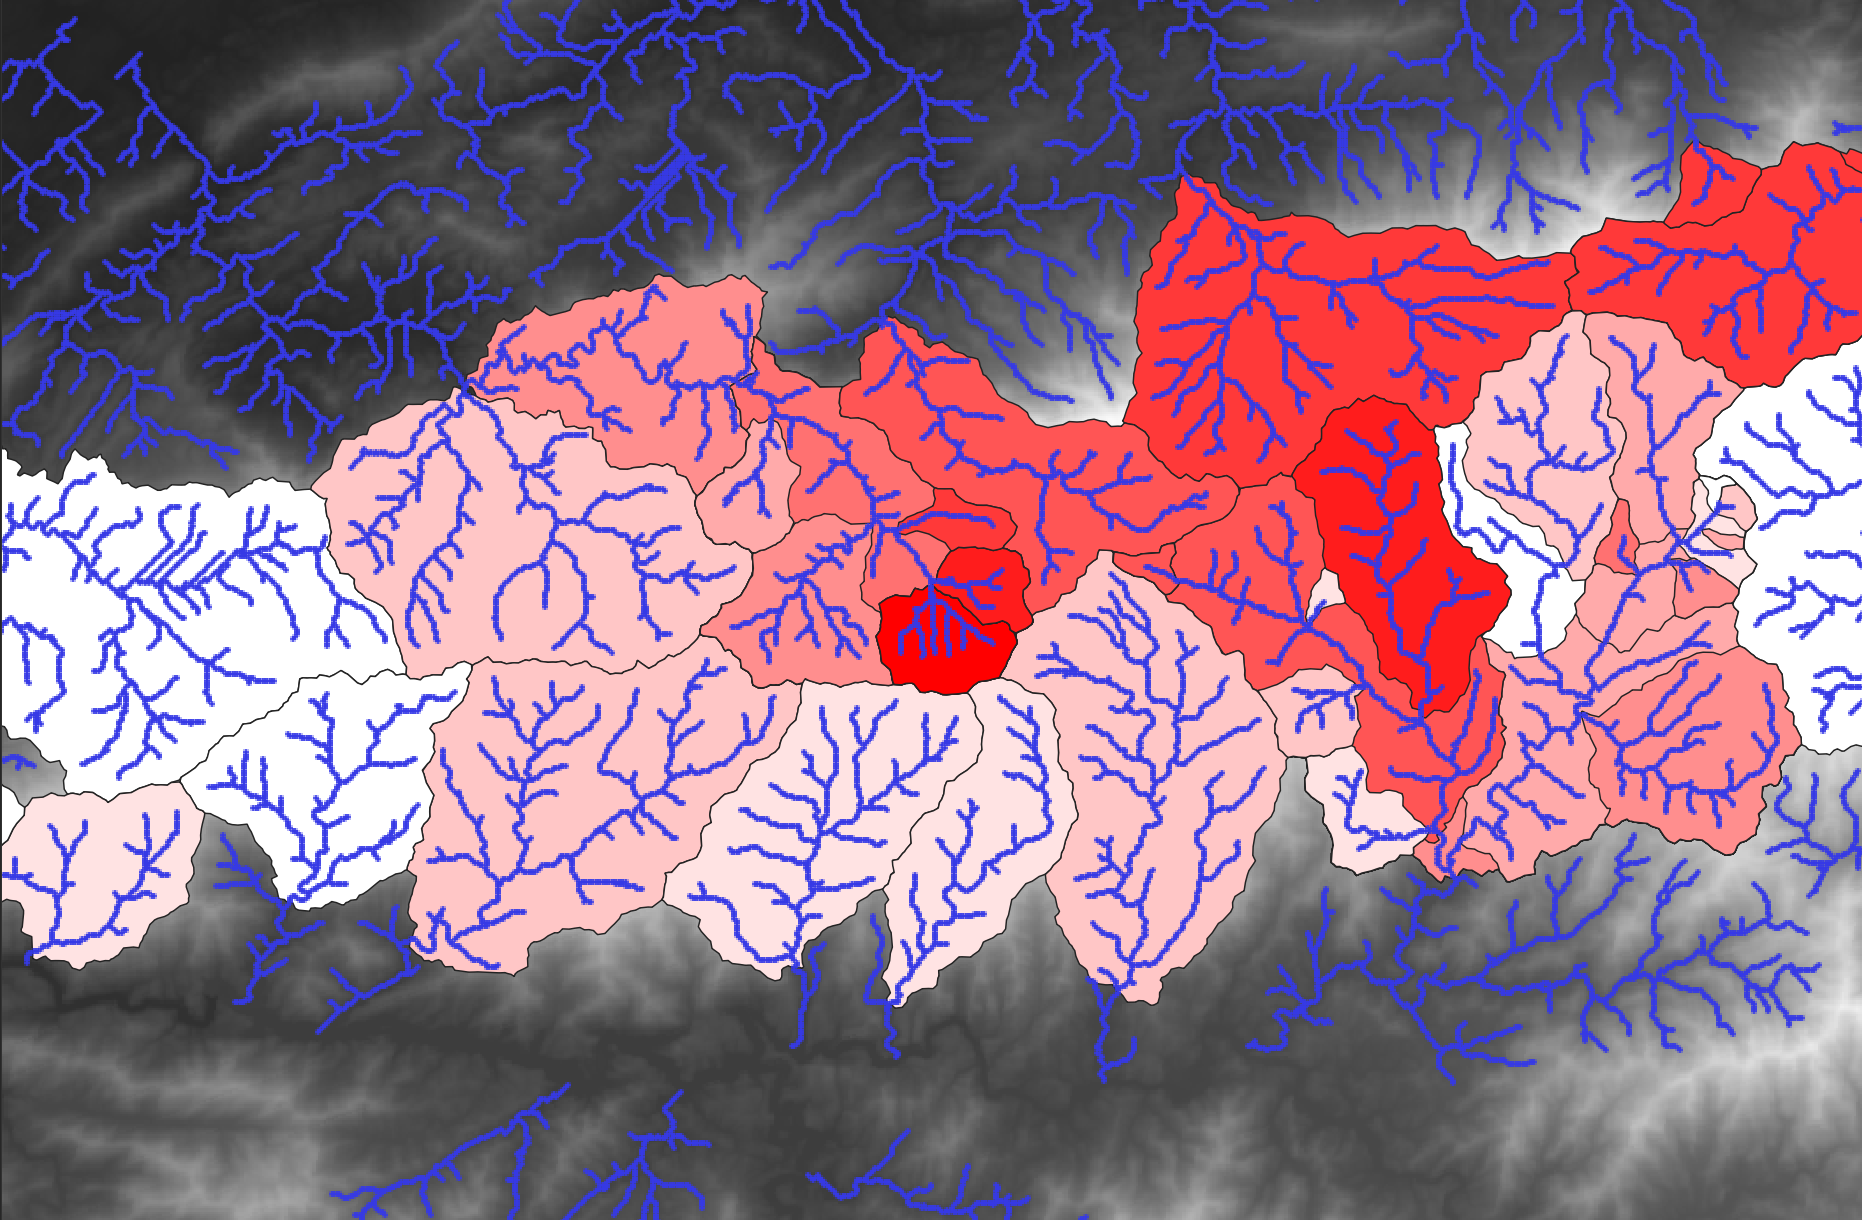 



---


## Exercise 2

* Download the file `Great_Smoky_Mts_MChiSegmented.geojson` and load into ArcGIS using the JSON to Features tool. Make a figure of the channel network coloured by channel steepness (the m_chi column) across the landscape. Write a short caption that explains how channel steepness varies across the landscape.

---



## Getting the mean channel steepness for each basin

Now we've got channel steepness for our landscape, we can find the mean values of channel steepness for each of the basins with erosion rate data. `geopanads` makes this easy to do, because we can simply look for each point on the river dataset that is within each basin polygon. That's what the code below does. First of all we will load in our channel steepness data to a second dataframe, and then merge it with the basins.

In [ ]:
# Load in the channel steepness data to a geopandas geodataframe
channel_gdf = gpd.read_file('Great_Smoky_Mts_MChiSegmented.geojson')

# convert this to the same coordinate system as the erosion rate data
target_crs = gdf.crs
channel_gdf = channel_gdf.to_crs(target_crs)

# Use a spatial join to merge the channel steepness data with the erosion rate data
new_gdf = gpd.sjoin(gdf, channel_gdf, how='left')

Now we will group the dataframe by the basin and get the mean steepness and standard deviation in each basin:

In [ ]:
mean_steepness = new_gdf.groupby('OBSID2')['m_chi'].agg({'mean', 'std'}).reset_index().rename(columns={'mean': 'mean_steepness', 'std': 'std_steepness'})
gdf = gdf.merge(mean_steepness, on='OBSID2')

Let's think about what relationship we might expect between channel steepness and erosion rate: if we pretend that we believe the stream power model, we get the following relationship between erosion rate ($E$) and channel steepness ($K_{s}$):

$ K_s = \Big(\frac{E}{K} \Big)^{1/n} $

This is a power law relationship ($K_s$ should scale with E to the power of $1/n$). We can take the log of both sides:

$ \log(K_s) = \frac{1}{n} log(E) -  \frac{1}{n}\log{K} $

This is an equation of a straight line where the gradient of the line is $1/n$ and the y intercept is $-\frac{1}{n}\log{K}.$. To test how well a power law fits our data, we can make a logarithmic plot of mean steepness against mean erosion rate.

In [ ]:
# plot the data
plt.scatter(gdf['mean_steepness'], gdf['EBE_MMKYR'], color='orange', edgecolors='black', s=100)
# add the axes labels
plt.xlabel('Channel steepness ($k_{sn}$)', fontsize=14)
plt.ylabel('Catchment-averaged\n erosion rate (mm/kyr)', fontsize=14)

# change to a log scale and set the ticklabels for the x axis
plt.xscale('log')
plt.xticks([60, 100, 200])
plt.yscale('log')

Let's do our linear regression again.

In [ ]:
# remove nans from the dataframe 
gdf = gdf[np.isnan(gdf['mean_steepness']) == False]

# set the X and Y data for the linear regression
x = gdf['mean_steepness']
y = gdf['EBE_MMKYR']

# do the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# print out the equation of the line. We will round to 2 decimal places
print ('y = {}x + {}'.format(round(slope,2), round(intercept,2)))

# print out the R^2 value and the p value
print ('R^2: ', r_value**2)
print ('p value: ', p_value)

## Adding error bars

An important part of dealing with measured data is _error_: this can either be measurement error, or natural variation within our sample that we might want to capture. 

Think about the two variables we are plotting against each other. The CRN erosion rates have an _analytical or measurement error_: these are errors that were calculated when the erosion rates were determined from the 10Be concentrations. 

How could we get some estimate of error on the mean basin slope, or the mean channel steepness? We could perhaps use some estimate of spread, or variance within the data, to estimate how well the mean represents the values within each basin. Here we will use the _standard deviation_ as our error bars, which gives us an indication of how much of our data lie within one standard deviation of the mean.

The code blocks below make the same plots as above, but add error bars for the CRN erosion rates, the mean basin slope, and the mean channel steepness.

In [ ]:
# make a scatter plot of erosion rates vs mean basin slope with error bars
plt.errorbar(gdf['MEAN'], gdf['EBE_MMKYR'], xerr=gdf['STD'], yerr=gdf['EBE_ERR'], fmt='none', color='grey', zorder=1)
plt.scatter(gdf['MEAN'], gdf['EBE_MMKYR'], color = 'red', edgecolors='black', s=100, zorder=2)
plt.xlabel('Mean basin slope (degrees)', fontsize=14)
plt.ylabel('Catchment-averaged\n erosion rate (mm/kyr)', fontsize=14)

In [ ]:
# make a scatter plot of channel steepness vs erosion rate with error bars
plt.errorbar(gdf['mean_steepness'], gdf['EBE_MMKYR'], xerr=gdf['std_steepness'], yerr=gdf['EBE_ERR'], fmt='none', color='grey', zorder=1)
plt.scatter(gdf['mean_steepness'], gdf['EBE_MMKYR'], color='orange', edgecolors='black', s=100)
plt.xlabel('Channel steepness ($k_{sn}$)', fontsize=14)
plt.ylabel('Catchment-averaged\n erosion rate (mm/kyr)', fontsize=14)

# change to a log scale and set the ticklabels for the x axis
plt.xscale('log')
plt.yscale('log')

------------------
## Exercise 3

1. Make a figure that shows the relationship between channel steepness, mean basin slope and catchment-averaged erosion rate for the basins. Write a short figure captions that explains what the figure shows and what it means for the relationship between topographic form and erosion rate.

2. Neither of these metrics seem to correlate particularly well with erosion rate in this landscape. Write down some reasons why you think this might be the case. You could think about i) the range of erosion rates measured; ii) the influence of climate, tectonics, lithology; iii) the influence of sediment.

## Appendix 1: Running channel steepness analysis on a DEM you have downloaded from OpenTopography - ONLY FOR INDEPENDENT PROJECT WORK

------------------------------
**NOTE**: If you are running this for your independent project and you have downloaded the DEM from OpenTopography, you will need to convert the DEM to a format that can be understood by LSDTopoTools. To do that, upload the original ".tif" file from OpenTopography to Google Colab and use the cell block below to convert it. This will probably be a file called `output_COP30.tif` if you have used the 30 m Copernicus DEM, or `output_COP90.tif` if you have used the 90m DEM. After running the block below you should end up with a ".bil" and a ".hdr" file. 
YOU WILL NEED TO SET THE UTM ZONE TO BE CORRECT FOR THE AREA YOU HAVE CHOSEN. You can look up the UTM Zone here: http://www.dmap.co.uk/utmworld.htm


In [ ]:
# RUN THIS CODE BLOCK TO CONVERT YOUR DEM TO THE RIGHT FORMAT

# First set the name of the DEM you have uploaded here WITH the extension. 
# So if you have a tif, you would put "DEM_name" for the Dataset_prefix variable and ".tif" for the extension. 
Dataset_prefix = "output_COP30"
Extension = '.tif'

import subprocess

# Below is the resolution of your data in metres. You should change this depending on whether you downloaded the 30 m or 90 m dataset from OpenTopography.
res = "30"

# Change the below UTM zone to the correct zone for your dataset (change the number after "+zone=")
pr = "+proj=utm +zone=10 +datum=WGS84"

# Dont change the stuff below this line
gd = "gdalwarp"
sr = "-t_srs"
of = "-of"
en = "ENVI"
ov = "-overwrite"
tr = "-tr"
r = "-r"
rm = "cubic"
infile = Dataset_prefix+Extension
outfile = Dataset_prefix+".bil"

subprocess_list = [gd, sr, pr, of, en, ov, tr, res, res, r, rm, infile, outfile]

subprocess.run(subprocess_list)

You should find a new file in your Google Colab files called `Dataset_prefix_COP30_UTM.bil`. We will use this to run the channel steepness code in the below cell block:

In [ ]:
DEM_name = Dataset_prefix

command_line_tool = "lsdtt-chi-mapping"
lsdtt_parameters = {"print_segmented_M_chi_map_to_csv" : "true", 
                    "print_basin_raster" : "true",
                    "convert_csv_to_geojson" : "true",
                    "threshold_contributing_pixels": "100"}

lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool,read_prefix = DEM_name,
                                 write_prefix= DEM_name,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

You should now have a file called `output_COP30_MChiSegmented.geojson`. You can download this and look at it in your GIS as for the practical. If you want to get the mean steepness for each basin, you can copy the cells from the "Getting the mean channel steepness in each basin" section below here and run them on your new dataset, but remember you will need to change the name of the file to match the `output_COP30_MChiSegmented.geojson` file.